Anjana Kamath Miyar | 011526762

## Introduction - Topic features using LDA ##

One of the primary applications of natural language processing is to automatically extract the topics from large volumes of text documents. I have used the "Liar Liar Pants on Fire" dataset and used LDA Topic modeling to extract most discussed topics.

### Import Packages ###

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Pradhan\Anaconda2\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Data Parsing from csv ###

In [2]:
dataset_train = pd.read_csv('train.tsv', delimiter = '\t', quoting = 3, header=None)
dataset_train.columns = ["id", "label", "statement", "subject", "speaker", "speaker_title", "State", "party_affiliation", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire","context"]
#dataset_train.head(5)
print dataset_train['statement'][:5]

0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
Name: statement, dtype: object


In [3]:
statement = dataset_train[['statement']]
statement['uuid'] = statement.index
document_news = statement
print len(document_news)
print document_news[:5]

C:\Users\Pradhan\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


10269
                                           statement  uuid
0  Says the Annies List political group supports ...     0
1  When did the decline of coal start? It started...     1
2  Hillary Clinton agrees with John McCain "by vo...     2
3  Health care reform legislation is likely to ma...     3
4  The economic turnaround started at the end of ...     4


## Data Preprocessing ##

##### Tokenization : Convert sentences to words #####
##### Converted words to lower case ##### 
##### Removed Stop words ##### 
##### Stemming is performed on the words to reduce the words to their root form ##### 
##### Lemmatization is performed to change words to first person and change the word to present tense ##### 

In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

doc_sample = document_news[document_news['uuid'] == 4310].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\nTokenized and lemmatized Document: ')
print(preprocess(doc_sample))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pradhan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
original document: 
['Says', 'state', 'Sen.', 'Morgan', 'Carrolls', 'votes', 'made', 'it', 'easier', 'to', 'sue', 'doctors,', 'small', 'businesses,', 'even', 'nurses.', 'Putting', 'her', 'own', 'shady', 'interests', 'first.']


Tokenized and lemmatized Document: 
[u'say', u'state', u'morgan', u'carrol', u'vote', u'easier', u'doctor', u'small', u'busi', u'nurs', u'put', u'shadi', u'interest']


### Choosing documents from preprocessed text ###

In [5]:
processed_statement = document_news['statement'].map(preprocess)
processed_statement[:10]

0    [say, anni, list, polit, group, support, trime...
1    [declin, coal, start, start, natur, take, star...
2    [hillari, clinton, agre, john, mccain, vote, g...
3    [health, care, reform, legisl, like, mandat, f...
4                    [econom, turnaround, start, term]
5    [chicago, bear, start, quarterback, year, tota...
6               [dunnam, live, district, repres, year]
7    [person, stage, work, activ, year, pass, russ,...
8    [take, million, oregon, lotteri, fund, port, n...
9    [say, primari, oppon, glenn, grothman, leibham...
Name: statement, dtype: object

### Creating bigrams and trigrams model ###

Bigrams are 2 words frequently occuring in the document and trigrams are 3 words frequently occuring in the document

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(processed_statement, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[processed_statement], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[processed_statement[0]]])

C:\Users\Pradhan\Anaconda2\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[u'say', u'anni', u'list', u'polit', u'group', u'support', u'trimest', u'abort', u'demand']


### Counting occurance of each words with their count ##

In [7]:
dictionary = gensim.corpora.Dictionary(processed_statement)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

(3268, u'foul')
(6618, u'interchang')
(4067, u'jihad')
(4065, u'suzann')
(6033, u'lord')
(3757, u'digit')
(1110, u'strictest')
(2860, u'broward')
(3802, u'disturb')
(5860, u'cianci')
(2617, u'whitman')


### Create a dictionary and corpus needed for Topic modeling ###

The 2 main inputs for LDA model are the dictionary and corpus. A unique id is generated for each word in a document. The  corpus outputs the mapping of word id and word frequency

In [8]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_statement]
bow_corpus[4310]

[(5, 1),
 (24, 1),
 (117, 1),
 (152, 1),
 (351, 1),
 (533, 1),
 (706, 1),
 (903, 1),
 (1060, 1)]

In [9]:
# Human readable format of corpus (term-frequency)
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 5 ("say") appears 1 time.
Word 24 ("vote") appears 1 time.
Word 117 ("state") appears 1 time.
Word 152 ("busi") appears 1 time.
Word 351 ("nurs") appears 1 time.
Word 533 ("small") appears 1 time.
Word 706 ("doctor") appears 1 time.
Word 903 ("put") appears 1 time.
Word 1060 ("interest") appears 1 time.


### Applying TF-IDF on bag of words corpus to get vectors ###

In [10]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3399028377044521),
 (1, 0.49960086945501425),
 (2, 0.40963633375026987),
 (3, 0.46333565607020666),
 (4, 0.40830190020991924),
 (5, 0.10872586224577774),
 (6, 0.27175617970851096)]


### Training the LDA(latent dirichlet allocation) model ###

LDA is a topic modeling approach which considers each document as a collection of topics and each topic as a collection of words. The algorithm takes topics as inputs and creates a topic distribution from the documents and and word distribution from the topics.

In [28]:
#Build LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=1500, id2word=dictionary, passes=2, workers=2)

C:\Users\Pradhan\Anaconda2\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


### View the topics in LDA model ###

Above LDA model is trained with 10 topics where each topic is a collection of words and each word contributes a certain weightage to that topic. For example Topic 0 comprises of following words 'say', 'state', 'billion' and so on and the weight of word 'say' is 0.076 

In [30]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.244*"muslim" + 0.177*"rubio" + 0.170*"say" + 0.158*"marco" + 0.106*"fact" + 0.076*"consid" + 0.021*"intern" + 0.017*"parti" + 0.014*"close" + 0.013*"compar"
Topic: 1 
Words: 0.032*"million" + 0.030*"person" + 0.029*"grant" + 0.029*"healthcar" + 0.029*"promis" + 0.028*"leav" + 0.027*"care" + 0.027*"feder" + 0.027*"thompson" + 0.024*"tommi"
Topic: 2 
Words: 0.717*"join" + 0.144*"state" + 0.034*"unit" + 0.008*"seven" + 0.006*"democrat" + 0.005*"senat" + 0.004*"group" + 0.004*"opportun" + 0.004*"choos" + 0.004*"republican"
Topic: 3 
Words: 0.339*"safe" + 0.229*"list" + 0.127*"gun" + 0.119*"peopl" + 0.086*"vote" + 0.026*"say" + 0.011*"purchas" + 0.010*"republican" + 0.008*"introduc" + 0.008*"famili"
Topic: 4 
Words: 0.004*"marriag" + 0.003*"texa" + 0.003*"year" + 0.003*"suprem" + 0.002*"licens" + 0.002*"coupl" + 0.002*"pension" + 0.002*"court" + 0.002*"strike" + 0.002*"salari"
Topic: 5 
Words: 0.192*"research" + 0.159*"cancer" + 0.142*"defens" + 0.124*"year" + 0.040*"citi

Words: 0.151*"trillion" + 0.124*"debt" + 0.080*"year" + 0.067*"govern" + 0.054*"cost" + 0.051*"vote" + 0.051*"feder" + 0.043*"congress" + 0.036*"ceil" + 0.032*"fund"
Topic: 46 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 47 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 48 
Words: 0.056*"nation" + 0.032*"offic" + 0.030*"econom" + 0.029*"kasich" + 0.028*"growth" + 0.028*"term" + 0.028*"take" + 0.027*"claim" + 0.025*"economi" + 0.023*"john"
Topic: 49 
Words: 0.428*"georg" + 0.306*"bush" + 0.031*"crisi" + 0.031*"go" + 0.031*"offic" + 0.024*"debt" + 0.020*"trillion" + 0.019*"inherit" + 0.015*"million" + 0.014*"walker"
Topic: 50 
Words: 0.324*"coverag" + 0.127*"health" + 0.113*"care" + 0.084*"american" + 0.069*"data" + 0.055*"year"

Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 91 
Words: 0.208*"health" + 0.088*"care" + 0.085*"individu" + 0.060*"plan" + 0.051*"feder" + 0.049*"purchas" + 0.048*"reform" + 0.047*"board" + 0.047*"benefit" + 0.046*"committe"
Topic: 92 
Words: 0.180*"percent" + 0.150*"bush" + 0.110*"year" + 0.055*"administr" + 0.055*"spend" + 0.055*"georg" + 0.055*"obama" + 0.055*"rais" + 0.054*"budget" + 0.053*"presid"
Topic: 93 
Words: 0.181*"exceed" + 0.153*"packag" + 0.095*"nation" + 0.090*"poverti" + 0.089*"averag" + 0.084*"rate" + 0.059*"percent" + 0.038*"board" + 0.029*"vote" + 0.026*"counti"
Topic: 94 
Words: 0.097*"fight" + 0.095*"pollut" + 0.086*"congressman" + 0.084*"support" + 0.065*"miami" + 0.057*"chang" + 0.050*"climat" + 0.050*"vote" + 0.044*"abil" + 0.042*"say"
Topic: 95 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" +

Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 136 
Words: 0.563*"combin" + 0.085*"previou" + 0.075*"america" + 0.055*"presid" + 0.055*"unit" + 0.038*"obama" + 0.035*"state" + 0.034*"term" + 0.029*"current" + 0.008*"rate"
Topic: 137 
Words: 0.524*"receiv" + 0.308*"benefit" + 0.097*"medicar" + 0.020*"dollar" + 0.018*"today" + 0.010*"retir" + 0.009*"coupl" + 0.006*"tax" + 0.000*"premium" + 0.000*"famili"
Topic: 138 
Words: 0.014*"state" + 0.012*"insur" + 0.012*"say" + 0.011*"polici" + 0.011*"allow" + 0.010*"citizen" + 0.009*"privat" + 0.009*"compani" + 0.009*"properti" + 0.008*"vote"
Topic: 139 
Words: 0.435*"requir" + 0.260*"exist" + 0.090*"absolut" + 0.048*"million" + 0.037*"year" + 0.020*"care" + 0.020*"cut" + 0.015*"health" + 0.010*"recess" + 0.008*"peopl"
Topic: 140 
Words: 0.175*"ask" + 0.169*"question" + 0.058*"presid" + 0.052*"peopl" + 0.041*"million" 

Words: 0.004*"care" + 0.003*"health" + 0.003*"medicaid" + 0.003*"women" + 0.002*"cost" + 0.002*"texa" + 0.002*"birth" + 0.002*"plan" + 0.002*"includ" + 0.002*"shoot"
Topic: 181 
Words: 0.278*"earth" + 0.077*"percent" + 0.072*"unemploy" + 0.067*"test" + 0.066*"go" + 0.045*"market" + 0.040*"actual" + 0.038*"nuclear" + 0.038*"rate" + 0.037*"labor"
Topic: 182 
Words: 0.429*"massiv" + 0.061*"complet" + 0.055*"million" + 0.031*"avail" + 0.029*"cost" + 0.029*"process" + 0.026*"year" + 0.023*"staff" + 0.021*"addit" + 0.021*"peopl"
Topic: 183 
Words: 0.275*"bring" + 0.113*"share" + 0.106*"fuel" + 0.076*"histor" + 0.063*"standard" + 0.051*"presid" + 0.050*"obama" + 0.041*"car" + 0.028*"cost" + 0.021*"budget"
Topic: 184 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 185 
Words: 0.372*"date" + 0.058*"campaign" + 0.056*"governor" + 0.051*"budget" + 0.046*"walker" + 0.04

Words: 0.132*"director" + 0.110*"michael" + 0.089*"organ" + 0.069*"legisl" + 0.068*"obama" + 0.067*"author" + 0.066*"provid" + 0.049*"valu" + 0.037*"million" + 0.032*"georgia"
Topic: 226 
Words: 0.142*"begin" + 0.129*"keep" + 0.122*"poverti" + 0.090*"american" + 0.075*"obama" + 0.069*"barack" + 0.061*"presid" + 0.058*"state" + 0.057*"year" + 0.041*"bureau"
Topic: 227 
Words: 0.180*"statist" + 0.179*"job" + 0.116*"year" + 0.093*"republican" + 0.085*"walker" + 0.081*"accord" + 0.071*"legislatur" + 0.067*"bureau" + 0.031*"labor" + 0.030*"control"
Topic: 228 
Words: 0.116*"tuition" + 0.113*"illeg" + 0.102*"immigr" + 0.089*"state" + 0.072*"say" + 0.065*"texa" + 0.059*"leadership" + 0.041*"care" + 0.039*"health" + 0.039*"presid"
Topic: 229 
Words: 0.150*"increas" + 0.137*"cost" + 0.132*"percent" + 0.091*"say" + 0.032*"unemploy" + 0.031*"male" + 0.030*"worst" + 0.030*"milwauke" + 0.030*"score" + 0.030*"graduat"
Topic: 230 
Words: 0.233*"worth" + 0.150*"remain" + 0.141*"oversea" + 0.076*"dolla

Words: 0.141*"say" + 0.115*"go" + 0.106*"your" + 0.084*"care" + 0.084*"pay" + 0.083*"health" + 0.075*"percent" + 0.055*"congression" + 0.054*"budget" + 0.054*"offic"
Topic: 271 
Words: 0.037*"women" + 0.025*"come" + 0.024*"health" + 0.023*"parenthood" + 0.022*"decad" + 0.022*"nearli" + 0.022*"dont" + 0.021*"rate" + 0.021*"plan" + 0.020*"time"
Topic: 272 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 273 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 274 
Words: 0.213*"rest" + 0.161*"million" + 0.093*"state" + 0.092*"look" + 0.085*"job" + 0.082*"texa" + 0.052*"creat" + 0.049*"decad" + 0.037*"time" + 0.034*"america"
Topic: 275 
Words: 0.151*"introduc" + 0.108*"presid" + 0.097*"strike" + 0.089*"obama" + 0.051*"time" + 0.045*"year" 

Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 316 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 317 
Words: 0.089*"say" + 0.083*"billion" + 0.057*"oversea" + 0.056*"credit" + 0.056*"stimulu" + 0.056*"build" + 0.056*"send" + 0.056*"plant" + 0.056*"mexico" + 0.056*"solar"
Topic: 318 
Words: 0.056*"prevent" + 0.047*"clinton" + 0.046*"write" + 0.046*"protect" + 0.046*"benghazi" + 0.045*"depart" + 0.045*"american" + 0.045*"fail" + 0.044*"attack" + 0.043*"libya"
Topic: 319 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 320 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"exte

Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 360 
Words: 0.229*"constitut" + 0.113*"didnt" + 0.096*"say" + 0.087*"year" + 0.074*"water" + 0.057*"drill" + 0.051*"time" + 0.041*"come" + 0.030*"hous" + 0.030*"state"
Topic: 361 
Words: 0.245*"percent" + 0.229*"pollut" + 0.221*"nineti" + 0.069*"state" + 0.052*"come" + 0.052*"local" + 0.035*"sourc" + 0.028*"outsid" + 0.019*"rhode" + 0.019*"island"
Topic: 362 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 363 
Words: 0.141*"unit" + 0.127*"world" + 0.095*"state" + 0.094*"year" + 0.065*"entir" + 0.062*"gun" + 0.039*"liber" + 0.032*"homicid" + 0.028*"citizen" + 0.026*"vote"
Topic: 364 
Words: 0.018*"purchas" + 0.017*"loophol" + 0.015*"want" + 0.013*"gun" + 0.013*"oper" + 0.013*"american"

Words: 0.392*"basic" + 0.256*"roll" + 0.106*"plan" + 0.076*"secur" + 0.053*"privat" + 0.045*"social" + 0.027*"talk" + 0.017*"congress" + 0.017*"there" + 0.000*"ceil"
Topic: 405 
Words: 0.447*"revenu" + 0.115*"percent" + 0.055*"cut" + 0.053*"incom" + 0.045*"state" + 0.032*"feder" + 0.025*"billion" + 0.020*"corpor" + 0.018*"peopl" + 0.016*"texa"
Topic: 406 
Words: 0.709*"american" + 0.097*"worst" + 0.065*"sarah" + 0.048*"palin" + 0.044*"obama" + 0.013*"senat" + 0.010*"histori" + 0.003*"john" + 0.003*"congressman" + 0.003*"associ"
Topic: 407 
Words: 0.534*"project" + 0.109*"million" + 0.083*"fund" + 0.076*"year" + 0.054*"remain" + 0.030*"move" + 0.027*"offic" + 0.019*"bridg" + 0.019*"leadership" + 0.016*"secur"
Topic: 408 
Words: 0.153*"benefit" + 0.084*"theyr" + 0.082*"experi" + 0.082*"compar" + 0.082*"good" + 0.082*"congressman" + 0.082*"nearli" + 0.081*"offer" + 0.062*"dont" + 0.044*"state"
Topic: 409 
Words: 0.084*"state" + 0.050*"say" + 0.050*"republican" + 0.045*"great" + 0.042*"his

Words: 0.250*"speaker" + 0.091*"hous" + 0.066*"presid" + 0.042*"senat" + 0.033*"million" + 0.024*"obama" + 0.017*"legisl" + 0.013*"work" + 0.012*"democrat" + 0.012*"run"
Topic: 450 
Words: 0.683*"today" + 0.236*"govern" + 0.017*"offic" + 0.009*"jersey" + 0.008*"leav" + 0.007*"christi" + 0.007*"state" + 0.005*"good" + 0.005*"januari" + 0.005*"fewer"
Topic: 451 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 452 
Words: 0.626*"investig" + 0.050*"year" + 0.046*"illeg" + 0.039*"fund" + 0.029*"case" + 0.027*"decad" + 0.027*"sale" + 0.027*"high" + 0.027*"terror" + 0.027*"half"
Topic: 453 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 454 
Words: 0.008*"refuge" + 0.005*"clinton" + 0.005*"call" + 0.005*"come" + 0.004*"percent" + 0.004*"f

Words: 0.121*"ceil" + 0.101*"debt" + 0.085*"nation" + 0.058*"percent" + 0.047*"pay" + 0.046*"averag" + 0.037*"countri" + 0.036*"time" + 0.035*"rais" + 0.030*"capita"
Topic: 495 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 496 
Words: 0.007*"drop" + 0.006*"come" + 0.006*"barack" + 0.006*"prior" + 0.006*"obama" + 0.006*"offic" + 0.005*"theyv" + 0.005*"hous" + 0.005*"price" + 0.005*"presid"
Topic: 497 
Words: 0.294*"lobbyist" + 0.145*"peopl" + 0.121*"staff" + 0.099*"question" + 0.066*"american" + 0.065*"hire" + 0.052*"care" + 0.050*"actual" + 0.044*"mccain" + 0.041*"campaign"
Topic: 498 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 499 
Words: 0.640*"state" + 0.070*"budget" + 0.041*"isnt" + 0.037*"commun" + 0.030*"percent" + 0.0

Words: 0.573*"run" + 0.047*"women" + 0.032*"rick" + 0.025*"tell" + 0.025*"million" + 0.022*"polici" + 0.021*"cost" + 0.021*"high" + 0.021*"forc" + 0.021*"sexual"
Topic: 540 
Words: 0.325*"committe" + 0.171*"minut" + 0.111*"page" + 0.098*"vote" + 0.062*"come" + 0.051*"amend" + 0.046*"bipartisan" + 0.044*"bank" + 0.040*"reach" + 0.038*"agreement"
Topic: 541 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 542 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 543 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 544 
Words: 0.332*"nanci" + 0.326*"pelosi" + 0.177*"vote" + 0.024*"republican" + 0.022*"firearm" + 0

Words: 0.189*"milwauke" + 0.182*"averag" + 0.150*"counti" + 0.098*"budget" + 0.052*"decreas" + 0.052*"citi" + 0.052*"board" + 0.052*"action" + 0.051*"thank" + 0.050*"home"
Topic: 585 
Words: 0.249*"convent" + 0.243*"extra" + 0.118*"transport" + 0.097*"cost" + 0.075*"come" + 0.065*"state" + 0.035*"add" + 0.031*"georgia" + 0.018*"busi" + 0.018*"larg"
Topic: 586 
Words: 0.238*"come" + 0.198*"think" + 0.170*"power" + 0.169*"state" + 0.086*"percent" + 0.063*"unit" + 0.024*"current" + 0.020*"california" + 0.019*"plant" + 0.007*"coast"
Topic: 587 
Words: 0.463*"administr" + 0.308*"execut" + 0.067*"spend" + 0.033*"million" + 0.023*"money" + 0.020*"compani" + 0.017*"health" + 0.016*"insur" + 0.015*"care" + 0.014*"cost"
Topic: 588 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 589 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" 

Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 630 
Words: 0.001*"class" + 0.001*"middl" + 0.001*"hous" + 0.001*"famili" + 0.001*"fail" + 0.001*"rhode" + 0.001*"feder" + 0.001*"cut" + 0.001*"island" + 0.001*"repres"
Topic: 631 
Words: 0.178*"mexico" + 0.148*"texa" + 0.121*"presid" + 0.113*"obama" + 0.112*"say" + 0.078*"citizen" + 0.069*"border" + 0.063*"barack" + 0.042*"matter" + 0.029*"happen"
Topic: 632 
Words: 0.195*"begin" + 0.110*"republican" + 0.085*"term" + 0.081*"state" + 0.068*"legisl" + 0.067*"go" + 0.052*"adjust" + 0.049*"success" + 0.043*"current" + 0.039*"unemploy"
Topic: 633 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 634 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.0

Words: 0.562*"see" + 0.161*"weve" + 0.115*"anti" + 0.026*"gener" + 0.026*"bill" + 0.022*"introduc" + 0.019*"women" + 0.014*"session" + 0.014*"half" + 0.014*"assembl"
Topic: 675 
Words: 0.440*"week" + 0.239*"special" + 0.106*"interest" + 0.035*"spend" + 0.032*"corpor" + 0.026*"work" + 0.022*"elect" + 0.010*"includ" + 0.009*"centuri" + 0.008*"propos"
Topic: 676 
Words: 0.156*"homeless" + 0.115*"say" + 0.053*"plan" + 0.046*"year" + 0.045*"state" + 0.024*"januari" + 0.019*"vote" + 0.017*"forward" + 0.017*"iran" + 0.017*"biden"
Topic: 677 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 678 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 679 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"

Words: 0.299*"sit" + 0.039*"report" + 0.038*"million" + 0.037*"presid" + 0.033*"offic" + 0.027*"job" + 0.026*"insur" + 0.025*"gener" + 0.023*"coast" + 0.023*"wast"
Topic: 720 
Words: 0.090*"percent" + 0.054*"month" + 0.051*"cost" + 0.050*"job" + 0.044*"plan" + 0.041*"republican" + 0.038*"market" + 0.037*"premium" + 0.037*"individu" + 0.035*"gain"
Topic: 721 
Words: 0.472*"amend" + 0.291*"believ" + 0.061*"second" + 0.059*"countri" + 0.025*"diseas" + 0.021*"state" + 0.010*"fastest" + 0.010*"grow" + 0.009*"unit" + 0.007*"highest"
Topic: 722 
Words: 0.114*"member" + 0.109*"hear" + 0.094*"plan" + 0.082*"public" + 0.057*"economi" + 0.057*"scott" + 0.057*"talk" + 0.057*"walker" + 0.057*"job" + 0.057*"charg"
Topic: 723 
Words: 0.343*"polic" + 0.215*"offic" + 0.156*"governor" + 0.108*"firefight" + 0.053*"say" + 0.033*"pension" + 0.019*"wisconsin" + 0.014*"respond" + 0.008*"tell" + 0.008*"walker"
Topic: 724 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 

Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 765 
Words: 0.441*"drug" + 0.286*"test" + 0.052*"peopl" + 0.039*"money" + 0.035*"save" + 0.031*"welfar" + 0.027*"deni" + 0.027*"benefit" + 0.010*"posit" + 0.009*"florida"
Topic: 766 
Words: 0.273*"account" + 0.253*"fall" + 0.141*"say" + 0.116*"year" + 0.090*"medicar" + 0.050*"certain" + 0.024*"billion" + 0.019*"go" + 0.006*"obamacar" + 0.006*"away"
Topic: 767 
Words: 0.439*"lawyer" + 0.102*"obama" + 0.063*"person" + 0.053*"year" + 0.048*"seven" + 0.042*"mayor" + 0.039*"major" + 0.037*"receiv" + 0.036*"financi" + 0.036*"figur"
Topic: 768 
Words: 0.508*"block" + 0.047*"american" + 0.040*"vote" + 0.032*"obamacar" + 0.031*"budget" + 0.030*"million" + 0.030*"say" + 0.023*"lose" + 0.023*"accord" + 0.023*"thank"
Topic: 769 
Words: 0.116*"religi" + 0.076*"favor" + 0.072*"go" + 0.054*"properti" + 0.052*"call" + 0.047*"bu

Words: 0.061*"today" + 0.054*"singl" + 0.052*"american" + 0.047*"lose" + 0.046*"compani" + 0.046*"mexico" + 0.045*"taxpay" + 0.044*"free" + 0.043*"gulf" + 0.042*"right"
Topic: 810 
Words: 0.001*"health" + 0.001*"plan" + 0.001*"engag" + 0.001*"insur" + 0.001*"compani" + 0.001*"condit" + 0.001*"medic" + 0.001*"peopl" + 0.001*"coverag" + 0.001*"continu"
Topic: 811 
Words: 0.141*"rais" + 0.136*"choic" + 0.078*"anti" + 0.076*"millionair" + 0.066*"tax" + 0.062*"trillion" + 0.045*"middl" + 0.043*"cut" + 0.042*"class" + 0.036*"averag"
Topic: 812 
Words: 0.385*"econom" + 0.302*"result" + 0.220*"recent" + 0.056*"polici" + 0.011*"georgia" + 0.007*"solar" + 0.004*"rate" + 0.004*"hike" + 0.002*"energi" + 0.000*"lobbyist"
Topic: 813 
Words: 0.102*"governor" + 0.091*"say" + 0.050*"wisconsin" + 0.045*"democrat" + 0.036*"republican" + 0.031*"women" + 0.029*"control" + 0.028*"parti" + 0.028*"conserv" + 0.026*"colleg"
Topic: 814 
Words: 0.107*"practic" + 0.090*"health" + 0.085*"deni" + 0.082*"condit" + 0

Words: 0.020*"trillion" + 0.020*"georg" + 0.019*"surplu" + 0.018*"pay" + 0.018*"borrow" + 0.018*"cut" + 0.017*"rich" + 0.016*"revenu" + 0.015*"secur" + 0.015*"iraq"
Topic: 855 
Words: 0.548*"case" + 0.123*"advoc" + 0.115*"penalti" + 0.062*"say" + 0.029*"violenc" + 0.028*"crime" + 0.027*"domest" + 0.020*"peopl" + 0.018*"like" + 0.011*"lower"
Topic: 856 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 857 
Words: 0.152*"folk" + 0.106*"extend" + 0.105*"cast" + 0.101*"vote" + 0.095*"say" + 0.065*"go" + 0.052*"work" + 0.039*"fail" + 0.034*"cut" + 0.031*"busi"
Topic: 858 
Words: 0.468*"scott" + 0.329*"walker" + 0.110*"state" + 0.042*"budget" + 0.009*"speaker" + 0.009*"balanc" + 0.008*"convict" + 0.006*"employe" + 0.004*"assembl" + 0.004*"help"
Topic: 859 
Words: 0.189*"matter" + 0.170*"job" + 0.161*"texa" + 0.132*"creat" + 0.127*"year" + 0.112*"fact" + 0.027*"ameri

Words: 0.392*"david" + 0.297*"order" + 0.160*"armi" + 0.081*"say" + 0.019*"forc" + 0.009*"carbon" + 0.008*"environment" + 0.008*"like" + 0.006*"hear" + 0.006*"damag"
Topic: 900 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 901 
Words: 0.052*"million" + 0.051*"year" + 0.028*"univers" + 0.028*"announc" + 0.027*"scienc" + 0.026*"budget" + 0.025*"depart" + 0.025*"florida" + 0.024*"past" + 0.024*"drop"
Topic: 902 
Words: 0.297*"charli" + 0.274*"crist" + 0.252*"veto" + 0.160*"million" + 0.001*"florida" + 0.001*"percent" + 0.001*"teach" + 0.000*"hospit" + 0.000*"univers" + 0.000*"have"
Topic: 903 
Words: 0.039*"nomin" + 0.037*"friend" + 0.033*"david" + 0.031*"commission" + 0.031*"retir" + 0.030*"plan" + 0.029*"rick" + 0.029*"perri" + 0.029*"run" + 0.029*"agricultur"
Topic: 904 
Words: 0.404*"bureaucrat" + 0.131*"care" + 0.095*"health" + 0.093*"washington" + 0.057

Words: 0.135*"say" + 0.069*"receiv" + 0.069*"grant" + 0.068*"famili" + 0.068*"program" + 0.068*"money" + 0.068*"agre" + 0.067*"bush" + 0.067*"million" + 0.067*"hold"
Topic: 945 
Words: 0.031*"million" + 0.018*"hillari" + 0.017*"clinton" + 0.015*"virtual" + 0.014*"say" + 0.014*"trade" + 0.013*"agreement" + 0.012*"worker" + 0.012*"vote" + 0.011*"berni"
Topic: 946 
Words: 0.724*"georgia" + 0.070*"year" + 0.049*"billion" + 0.037*"say" + 0.035*"cost" + 0.015*"particip" + 0.010*"million" + 0.008*"elimin" + 0.006*"school" + 0.005*"student"
Topic: 947 
Words: 0.140*"state" + 0.071*"break" + 0.071*"leader" + 0.071*"away" + 0.069*"fund" + 0.069*"school" + 0.069*"billion" + 0.068*"increas" + 0.068*"basic" + 0.068*"say"
Topic: 948 
Words: 0.088*"life" + 0.040*"year" + 0.038*"earn" + 0.037*"pelosi" + 0.037*"hous" + 0.036*"minor" + 0.036*"dollar" + 0.036*"congression" + 0.034*"nanci" + 0.033*"free"
Topic: 949 
Words: 0.127*"grade" + 0.127*"school" + 0.106*"gain" + 0.092*"high" + 0.068*"state" + 0.06

Words: 0.489*"liber" + 0.205*"polit" + 0.072*"say" + 0.066*"obama" + 0.035*"requir" + 0.028*"union" + 0.015*"presid" + 0.012*"prison" + 0.012*"includ" + 0.011*"basic"
Topic: 990 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 991 
Words: 0.058*"state" + 0.035*"worker" + 0.033*"illeg" + 0.032*"job" + 0.030*"loophol" + 0.028*"budget" + 0.026*"measur" + 0.024*"repeal" + 0.022*"construct" + 0.020*"wisconsin"
Topic: 992 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 993 
Words: 0.435*"growth" + 0.192*"figur" + 0.178*"wisconsin" + 0.019*"trillion" + 0.014*"presid" + 0.014*"creation" + 0.013*"spend" + 0.013*"privat" + 0.012*"wealthi" + 0.012*"drug"
Topic: 994 
Words: 0.387*"legal" + 0.370*"meet" + 0.110*"statewid" + 0.034*"offic" + 0.01

Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1034 
Words: 0.467*"afford" + 0.293*"care" + 0.058*"major" + 0.048*"american" + 0.022*"dont" + 0.021*"want" + 0.011*"larg" + 0.010*"think" + 0.010*"small" + 0.009*"protect"
Topic: 1035 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1036 
Words: 0.156*"percent" + 0.112*"health" + 0.097*"cost" + 0.089*"initi" + 0.084*"nearli" + 0.068*"accord" + 0.061*"care" + 0.059*"studi" + 0.054*"peopl" + 0.047*"say"
Topic: 1037 
Words: 0.614*"that" + 0.220*"year" + 0.088*"come" + 0.046*"percent" + 0.017*"there" + 0.005*"averag" + 0.001*"period" + 0.000*"econom" + 0.000*"growth" + 0.000*"ronald"
Topic: 1038 
Words: 0.662*"send" + 0.254*"get" + 0.026*"dollar" + 0.016*"state" + 0.012*"washington" + 0.0

Words: 0.084*"say" + 0.081*"global" + 0.077*"obama" + 0.066*"time" + 0.066*"guard" + 0.062*"number" + 0.061*"warm" + 0.053*"increas" + 0.044*"threat" + 0.031*"percent"
Topic: 1079 
Words: 0.201*"vote" + 0.186*"fact" + 0.174*"town" + 0.159*"peopl" + 0.129*"favor" + 0.044*"obamacar" + 0.036*"medicar" + 0.030*"spend" + 0.029*"that" + 0.001*"gallon"
Topic: 1080 
Words: 0.753*"term" + 0.081*"indic" + 0.033*"illeg" + 0.027*"cross" + 0.025*"number" + 0.017*"immigr" + 0.014*"fewer" + 0.014*"enforc" + 0.012*"actual" + 0.012*"action"
Topic: 1081 
Words: 0.168*"period" + 0.157*"grow" + 0.149*"percent" + 0.069*"nation" + 0.054*"administr" + 0.054*"number" + 0.043*"bailout" + 0.041*"presid" + 0.039*"popul" + 0.036*"job"
Topic: 1082 
Words: 0.001*"health" + 0.001*"women" + 0.001*"parenthood" + 0.001*"plan" + 0.001*"percent" + 0.001*"receiv" + 0.001*"screen" + 0.001*"nearli" + 0.001*"program" + 0.001*"center"
Topic: 1083 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"e

Words: 0.286*"better" + 0.128*"differ" + 0.112*"rest" + 0.085*"school" + 0.077*"percent" + 0.075*"nation" + 0.045*"studi" + 0.043*"signific" + 0.039*"public" + 0.031*"show"
Topic: 1124 
Words: 0.252*"romney" + 0.226*"mitt" + 0.211*"say" + 0.107*"point" + 0.095*"massachusett" + 0.068*"kill" + 0.033*"governor" + 0.007*"plant" + 0.001*"coal" + 0.001*"stand"
Topic: 1125 
Words: 0.235*"cost" + 0.114*"estim" + 0.102*"averag" + 0.077*"say" + 0.075*"budget" + 0.073*"equival" + 0.072*"offic" + 0.070*"congression" + 0.066*"trade" + 0.051*"famili"
Topic: 1126 
Words: 0.331*"turn" + 0.132*"inflat" + 0.076*"state" + 0.072*"say" + 0.070*"adjust" + 0.036*"dollar" + 0.032*"fund" + 0.028*"revenu" + 0.027*"gener" + 0.026*"syrian"
Topic: 1127 
Words: 0.291*"water" + 0.149*"say" + 0.092*"core" + 0.085*"portland" + 0.069*"reason" + 0.062*"peopl" + 0.039*"bureau" + 0.032*"want" + 0.024*"rat" + 0.023*"high"
Topic: 1128 
Words: 0.274*"gulf" + 0.271*"sourc" + 0.171*"includ" + 0.053*"percent" + 0.033*"day" + 0.

Words: 0.030*"year" + 0.025*"percent" + 0.019*"bring" + 0.017*"dramat" + 0.016*"bear" + 0.016*"state" + 0.016*"governor" + 0.016*"spend" + 0.015*"minnesota" + 0.015*"increas"
Topic: 1169 
Words: 0.450*"program" + 0.236*"compar" + 0.144*"bridg" + 0.107*"go" + 0.030*"billion" + 0.008*"stimulu" + 0.007*"road" + 0.005*"democrat" + 0.005*"propos" + 0.000*"extend"
Topic: 1170 
Words: 0.028*"worker" + 0.026*"wall" + 0.024*"street" + 0.023*"labor" + 0.023*"percent" + 0.023*"board" + 0.022*"studi" + 0.021*"cost" + 0.020*"independ" + 0.020*"fund"
Topic: 1171 
Words: 0.133*"watch" + 0.124*"pick" + 0.102*"texan" + 0.077*"famili" + 0.062*"take" + 0.055*"say" + 0.048*"countri" + 0.044*"obama" + 0.042*"state" + 0.038*"highest"
Topic: 1172 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1173 
Words: 0.150*"weve" + 0.104*"sentenc" + 0.063*"white" + 0.061*"give" + 0.044*"say"

Words: 0.266*"wage" + 0.246*"minimum" + 0.198*"wag" + 0.117*"annual" + 0.058*"increas" + 0.040*"million" + 0.017*"cost" + 0.012*"govern" + 0.009*"state" + 0.008*"affect"
Topic: 1213 
Words: 0.085*"plan" + 0.068*"recent" + 0.065*"deficit" + 0.059*"surplu" + 0.055*"creat" + 0.055*"care" + 0.055*"come" + 0.055*"health" + 0.054*"congression" + 0.054*"current"
Topic: 1214 
Words: 0.335*"american" + 0.334*"african" + 0.120*"own" + 0.095*"say" + 0.050*"want" + 0.020*"percent" + 0.007*"busi" + 0.006*"tax" + 0.005*"pay" + 0.005*"rais"
Topic: 1215 
Words: 0.043*"state" + 0.027*"union" + 0.025*"delay" + 0.022*"leav" + 0.021*"power" + 0.020*"provid" + 0.019*"constitut" + 0.019*"wisconsin" + 0.019*"democrat" + 0.018*"week"
Topic: 1216 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1217 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend

Words: 0.628*"hour" + 0.061*"spend" + 0.050*"work" + 0.043*"go" + 0.025*"money" + 0.018*"countri" + 0.018*"cent" + 0.018*"wage" + 0.018*"bridg" + 0.018*"minimum"
Topic: 1258 
Words: 0.197*"leadership" + 0.176*"elimin" + 0.083*"program" + 0.069*"state" + 0.068*"nation" + 0.058*"say" + 0.036*"job" + 0.034*"republican" + 0.028*"spend" + 0.018*"govern"
Topic: 1259 
Words: 0.188*"transport" + 0.148*"addit" + 0.141*"job" + 0.117*"year" + 0.081*"propos" + 0.079*"creat" + 0.060*"atlanta" + 0.060*"includ" + 0.048*"govern" + 0.032*"support"
Topic: 1260 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1261 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1262 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend

Words: 0.371*"unemploy" + 0.151*"consecut" + 0.143*"percent" + 0.066*"month" + 0.051*"rate" + 0.049*"governor" + 0.048*"state" + 0.033*"lowest" + 0.028*"countri" + 0.025*"say"
Topic: 1302 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1303 
Words: 0.340*"global" + 0.272*"threat" + 0.129*"presid" + 0.061*"go" + 0.031*"terror" + 0.029*"trump" + 0.029*"donald" + 0.019*"face" + 0.018*"list" + 0.018*"economi"
Topic: 1304 
Words: 0.345*"tri" + 0.199*"israel" + 0.163*"iran" + 0.099*"say" + 0.089*"countri" + 0.021*"presid" + 0.020*"saudi" + 0.020*"nuclear" + 0.015*"deal" + 0.006*"program"
Topic: 1305 
Words: 0.173*"discrimin" + 0.121*"perri" + 0.089*"rick" + 0.089*"feder" + 0.078*"say" + 0.067*"write" + 0.065*"peopl" + 0.048*"sign" + 0.048*"actual" + 0.044*"court"
Topic: 1306 
Words: 0.148*"countri" + 0.125*"best" + 0.084*"state" + 0.068*"wisconsin" + 0.056*"year" 

Words: 0.018*"includ" + 0.015*"nation" + 0.014*"econom" + 0.014*"increas" + 0.010*"budget" + 0.010*"revenu" + 0.009*"recoveri" + 0.009*"refuge" + 0.009*"project" + 0.009*"expect"
Topic: 1347 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1348 
Words: 0.261*"workforc" + 0.205*"work" + 0.105*"labor" + 0.070*"look" + 0.043*"current" + 0.043*"lowest" + 0.032*"level" + 0.031*"rate" + 0.030*"particip" + 0.029*"stand"
Topic: 1349 
Words: 0.039*"congression" + 0.038*"budget" + 0.037*"cut" + 0.035*"health" + 0.034*"deficit" + 0.033*"second" + 0.033*"year" + 0.031*"reform" + 0.031*"legisl" + 0.030*"insur"
Topic: 1350 
Words: 0.019*"rate" + 0.014*"graduat" + 0.012*"nation" + 0.010*"florida" + 0.009*"continu" + 0.009*"high" + 0.008*"increas" + 0.007*"school" + 0.007*"lead" + 0.007*"fastest"
Topic: 1351 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"full

Words: 0.678*"union" + 0.130*"state" + 0.092*"address" + 0.021*"time" + 0.021*"presid" + 0.017*"obama" + 0.013*"word" + 0.011*"barack" + 0.001*"sector" + 0.001*"privat"
Topic: 1391 
Words: 0.001*"constitut" + 0.001*"govern" + 0.001*"take" + 0.001*"hillari" + 0.001*"clinton" + 0.001*"illeg" + 0.001*"foreign" + 0.001*"foundat" + 0.001*"secretari" + 0.001*"money"
Topic: 1392 
Words: 0.755*"your" + 0.051*"american" + 0.044*"countri" + 0.020*"give" + 0.020*"like" + 0.019*"unit" + 0.013*"plan" + 0.013*"govern" + 0.011*"central" + 0.007*"say"
Topic: 1393 
Words: 0.104*"studi" + 0.073*"energi" + 0.068*"billion" + 0.066*"say" + 0.054*"percent" + 0.054*"total" + 0.053*"need" + 0.053*"depart" + 0.053*"best" + 0.053*"solar"
Topic: 1394 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1395 
Words: 0.049*"highest" + 0.041*"nation" + 0.034*"properti" + 0.030*"tax" + 0.022*"

Words: 0.631*"happen" + 0.083*"time" + 0.039*"sector" + 0.036*"come" + 0.032*"governor" + 0.031*"public" + 0.023*"rate" + 0.021*"privat" + 0.020*"creation" + 0.017*"romney"
Topic: 1435 
Words: 0.168*"time" + 0.110*"percent" + 0.087*"spend" + 0.084*"revenu" + 0.059*"govern" + 0.051*"high" + 0.050*"feder" + 0.045*"right" + 0.038*"close" + 0.036*"say"
Topic: 1436 
Words: 0.148*"gallon" + 0.129*"loss" + 0.103*"gener" + 0.103*"take" + 0.102*"studi" + 0.101*"produc" + 0.063*"percent" + 0.045*"research" + 0.028*"mean" + 0.025*"energi"
Topic: 1437 
Words: 0.135*"percent" + 0.126*"stimulu" + 0.090*"govern" + 0.084*"economi" + 0.049*"cost" + 0.048*"guarante" + 0.047*"money" + 0.035*"earli" + 0.032*"health" + 0.027*"care"
Topic: 1438 
Words: 0.001*"theyr" + 0.001*"doctor" + 0.001*"ceil" + 0.001*"fulli" + 0.001*"extend" + 0.001*"train" + 0.001*"speed" + 0.001*"despit" + 0.001*"intern" + 0.001*"stadium"
Topic: 1439 
Words: 0.252*"get" + 0.118*"capita" + 0.111*"percent" + 0.108*"state" + 0.105*"aver

Words: 0.464*"tell" + 0.146*"say" + 0.090*"worker" + 0.027*"feder" + 0.023*"walker" + 0.018*"report" + 0.018*"like" + 0.018*"requir" + 0.017*"healthcar" + 0.016*"wage"
Topic: 1479 
Words: 0.037*"fund" + 0.029*"pelosi" + 0.028*"regul" + 0.028*"vote" + 0.025*"firearm" + 0.024*"liber" + 0.023*"nanci" + 0.022*"republican" + 0.022*"mike" + 0.021*"program"
Topic: 1480 
Words: 0.045*"tell" + 0.044*"say" + 0.043*"inform" + 0.041*"high" + 0.039*"obamacar" + 0.038*"compani" + 0.038*"impact" + 0.038*"think" + 0.038*"insur" + 0.038*"human"
Topic: 1481 
Words: 0.102*"novemb" + 0.091*"obama" + 0.087*"peopl" + 0.076*"need" + 0.071*"say" + 0.068*"american" + 0.066*"elect" + 0.066*"oppon" + 0.063*"hous" + 0.059*"presid"
Topic: 1482 
Words: 0.065*"american" + 0.059*"million" + 0.050*"citi" + 0.041*"obama" + 0.036*"presid" + 0.034*"stamp" + 0.033*"say" + 0.032*"food" + 0.032*"billion" + 0.032*"budget"
Topic: 1483 
Words: 0.001*"mean" + 0.001*"scott" + 0.001*"lose" + 0.001*"billion" + 0.001*"size" + 0.001

### Applying LDA on TF-IDF ###

In [31]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.015*"say" + 0.010*"texa" + 0.010*"clinton" + 0.010*"year" + 0.009*"florida" + 0.009*"hillari" + 0.007*"spend" + 0.007*"state" + 0.007*"health" + 0.006*"govern"
Topic: 1 Word: 0.013*"say" + 0.010*"obama" + 0.010*"state" + 0.010*"romney" + 0.009*"presid" + 0.009*"tax" + 0.008*"mitt" + 0.008*"rais" + 0.007*"campaign" + 0.007*"governor"
Topic: 2 Word: 0.016*"say" + 0.014*"percent" + 0.012*"tax" + 0.010*"state" + 0.010*"vote" + 0.008*"year" + 0.007*"health" + 0.007*"rais" + 0.007*"voter" + 0.007*"spend"
Topic: 3 Word: 0.016*"job" + 0.012*"say" + 0.012*"state" + 0.011*"creat" + 0.011*"wisconsin" + 0.010*"percent" + 0.010*"citi" + 0.009*"scott" + 0.008*"million" + 0.008*"walker"
Topic: 4 Word: 0.017*"percent" + 0.015*"year" + 0.011*"health" + 0.011*"state" + 0.010*"school" + 0.010*"say" + 0.010*"care" + 0.009*"nation" + 0.008*"averag" + 0.008*"incom"
Topic: 5 Word: 0.016*"say" + 0.010*"year" + 0.009*"state" + 0.008*"obama" + 0.008*"unemploy" + 0.007*"presid" + 0.007*"tri" + 0

In [32]:
processed_statement[4310]

[u'say',
 u'state',
 u'morgan',
 u'carrol',
 u'vote',
 u'easier',
 u'doctor',
 u'small',
 u'busi',
 u'nurs',
 u'put',
 u'shadi',
 u'interest']

### Testing using bag of words by applying LDA ###

In [33]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.382366359234	 
Topic: 0.201*"nurs" + 0.170*"home" + 0.122*"say" + 0.053*"go" + 0.053*"vote" + 0.051*"wisconsin" + 0.048*"increas" + 0.044*"taxpay" + 0.037*"state" + 0.023*"budget"

Score: 0.200066655874	 
Topic: 0.426*"busi" + 0.371*"small" + 0.047*"rais" + 0.039*"plan" + 0.025*"tax" + 0.025*"kind" + 0.014*"democrat" + 0.013*"loan" + 0.008*"job" + 0.008*"rat"

Score: 0.116882666945	 
Topic: 0.215*"deni" + 0.157*"put" + 0.123*"care" + 0.117*"medicar" + 0.103*"say" + 0.094*"senior" + 0.056*"obama" + 0.053*"current" + 0.025*"charg" + 0.016*"bureaucrat"

Score: 0.100066676736	 
Topic: 0.440*"week" + 0.239*"special" + 0.106*"interest" + 0.035*"spend" + 0.032*"corpor" + 0.026*"work" + 0.022*"elect" + 0.010*"includ" + 0.009*"centuri" + 0.008*"propos"

Score: 0.0625788122416	 
Topic: 0.269*"releas" + 0.183*"doctor" + 0.085*"benghazi" + 0.078*"press" + 0.074*"republican" + 0.046*"offici" + 0.045*"administr" + 0.042*"tri" + 0.032*"actual" + 0.031*"email"

Score: 0.0384388193488	 
Topic

### Applying LDA on unknown document ###

In [34]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.909978806973	 
Topic: 0.717*"join" + 0.144*"state" + 0.034*"unit" + 0.008*"seven" + 0.006*"democrat" + 0.005*"senat" + 0.004*"group" + 0.004*"opportun" + 0.004*"choos" + 0.004*"republican"

Score: 0.0100043602288	 
Topic: 0.230*"care" + 0.141*"health" + 0.091*"lowest" + 0.088*"percent" + 0.080*"year" + 0.077*"growth" + 0.075*"afford" + 0.040*"spend" + 0.040*"grow" + 0.040*"rate"

Score: 0.0100034987554	 
Topic: 0.192*"research" + 0.159*"cancer" + 0.142*"defens" + 0.124*"year" + 0.040*"citi" + 0.038*"depart" + 0.037*"base" + 0.035*"percent" + 0.033*"offic" + 0.031*"million"

Score: 0.0100028533489	 
Topic: 0.032*"million" + 0.030*"person" + 0.029*"grant" + 0.029*"healthcar" + 0.029*"promis" + 0.028*"leav" + 0.027*"care" + 0.027*"feder" + 0.027*"thompson" + 0.024*"tommi"

Score: 0.0100027713925	 
Topic: 0.277*"attorney" + 0.256*"public" + 0.134*"texa" + 0.094*"prosecut" + 0.060*"offici" + 0.037*"violat" + 0.035*"district" + 0.034*"gener" + 0.025*"judg" + 0.025*"trust"

Score: 0

### Computing model perplexity and coherence score ###

LDA topic model gave a coherence score of 0.21. LDA Mallet Model - Gensim provides a wrapper to implement Mallet’s LDA is said to give better quality of topics

In [35]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_statement, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

('\nPerplexity: ', -14.613025021435064)
('\nCoherence Score: ', 0.4381146190389922)


### Visualization of Topic keywords ###

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

C:\Users\Pradhan\Anaconda2\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      12.077080        1       1 -0.062385 -0.012768
1      11.034909        1       2  0.098324 -0.008678
7      10.657852        1       3 -0.100159 -0.001435
4      10.566960        1       4 -0.063123  0.032018
9      10.455270        1       5  0.008286 -0.006450
3      10.235923        1       6  0.063967  0.072721
0       9.723151        1       7  0.007119 -0.015235
6       9.294259        1       8  0.045265 -0.100928
8       8.041022        1       9 -0.010740 -0.060562
2       7.913579        1      10  0.013445  0.101317, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
1001  Default  2700.000000         say  2700.000000  30.0000  30.0000
343   Default   330.000000    democrat   330.000000  29.0000  29.0000
360   Default   606.000000      health   606.000000  28.0000  28.0000
387   Default   508.000000        care   508.000000  27.0000  27.0000
320   Default   369.000000  republican   369.000000  26.0000  26.0000
346   Default  1200.000000        year  1200.000000  25.0000  25.0000
930   Default   282.000000     clinton   282.000000  24.0000  24.0000
450   Default   851.000000       obama   851.000000  23.0000  23.0000
438   Default   199.000000     hillari   199.000000  22.0000  22.0000
964   Default   445.000000     billion   445.000000  21.0000  21.0000
1008  Default   191.000000      romney   191.000000  20.0000  20.0000
894   Default   136.000000        mitt   136.000000  19.0000  19.0000
620   Default  1366.000000       state  1366.000000  18.0000  18.0000
914   Default   117.000000      island   117.000000  17.0000  17.0000
617   Default   107.000000       rhode   107.000000  16.0000  16.0000
792   Default   449.000000       spend   449.000000  15.0000  15.0000
305   Default   293.000000       senat   293.000000  14.0000  14.0000
541   Default   382.000000        texa   382.000000  13.0000  13.0000
417   Default   651.000000        vote   651.000000  12.0000  12.0000
142   Default   311.000000        unit   311.000000  11.0000  11.0000
498   Default   229.000000       insur   229.000000  10.0000  10.0000
770   Default   412.000000     countri   412.000000   9.0000   9.0000
3     Default   238.000000      dollar   238.000000   8.0000   8.0000
636   Default   482.000000         job   482.000000   7.0000   7.0000
167   Default   577.000000       peopl   577.000000   6.0000   6.0000
226   Default   457.000000    american   457.000000   5.0000   5.0000
200   Default   171.000000       trump   171.000000   4.0000   4.0000
119   Default   164.000000      social   164.000000   3.0000   3.0000
89    Default   202.000000       elect   202.000000   2.0000   2.0000
391   Default   262.000000     florida   262.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
230   Topic10    11.817265    recoveri    32.696053   1.5189  -6.1937
391   Topic10    84.048164     florida   262.930603   1.3961  -4.2319
305   Topic10    81.745277       senat   293.311096   1.2590  -4.2597
850   Topic10    56.847046        like   195.104401   1.3034  -4.6229
85    Topic10    62.824379      public   221.968567   1.2744  -4.5229
1007  Topic10    23.946062      revenu    74.261024   1.4048  -5.4875
322   Topic10    22.375418         day    68.816971   1.4131  -5.5553
1010  Topic10    18.317068       drive    56.139229   1.4166  -5.7554
114   Topic10    26.888309    milwauke    96.152908   1.2623  -5.3716
653   Topic10    19.328440     foreign    62.694344   1.3599  -5.7017
33    Topic10    18.624136        rise    59.920624   1.3680  -5.7388
68    Topic10    53.797882        cost   291.785126   0.8458  -4.6780
620   Topic10   142.584625       state  1366.254761   0.2767  -3.7033
1001  Topic10   217.096100         say  2700.417236   0.0158  -3.2829
1026  Topic10   122

### Optimal number of topics for LDA ###

To find the optimal number of topics build LDA models with different value of number of topics k and pick the one with highest coherence

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        #model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=processed_statement, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_statement, start=2, limit=40, step=6)

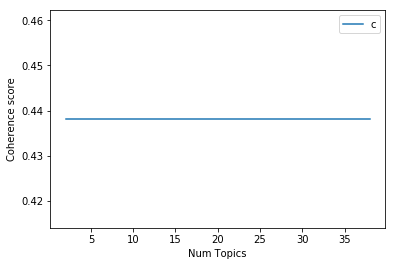

In [38]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

('Num Topics =', 2, ' has Coherence Value of', 0.4381)
('Num Topics =', 8, ' has Coherence Value of', 0.4381)
('Num Topics =', 14, ' has Coherence Value of', 0.4381)
('Num Topics =', 20, ' has Coherence Value of', 0.4381)
('Num Topics =', 26, ' has Coherence Value of', 0.4381)
('Num Topics =', 32, ' has Coherence Value of', 0.4381)
('Num Topics =', 38, ' has Coherence Value of', 0.4381)


### Finding the dominant topic in each document ###

To find what the topic is about in a given document and to find a topic number that has highest percentage of contribution in that document

In [45]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_statement):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_statement)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,413.0,0.3712,"support, abort, hillari, includ, clinton, dema...","[say, anni, list, polit, group, support, trime..."
1,1,1227.0,0.7170,"start, administr, natur, presid, bush, coal, b...","[declin, coal, start, start, natur, take, star..."
2,2,49.0,0.1819,"georg, bush, crisi, go, offic, debt, trillion,...","[hillari, clinton, agre, john, mccain, vote, g..."
3,3,76.0,0.2037,"health, care, governor, say, year, reform, spe...","[health, care, reform, legisl, like, mandat, f..."
4,4,1080.0,0.2502,"term, indic, illeg, cross, number, immigr, few...","[econom, turnaround, start, term]"
5,5,1148.0,0.2338,"bear, year, percent, increas, dramat, time, sp...","[chicago, bear, start, quarterback, year, tota..."
6,6,186.0,0.4001,"district, school, say, chines, texa, year, bon...","[dunnam, live, district, repres, year]"
7,7,1224.0,0.1980,"mandat, say, vote, feingold, russ, super, dont...","[person, stage, work, activ, year, pass, russ,..."
8,8,121.0,0.2223,"oregon, legislatur, say, author, simpli, milli...","[take, million, oregon, lotteri, fund, port, n..."
9,9,1421.0,0.2857,"primari, say, vote, republican, report, percen...","[say, primari, oppon, glenn, grothman, leibham..."


In [44]:
print df_dominant_topic.count()

Document_No           10269
Dominant_Topic        10233
Topic_Perc_Contrib    10233
Keywords              10233
Text                  10269
dtype: int64


In [46]:
import pandas
import csv

header = ['Topic_Perc_Contrib', 'Text']
df_dominant_topic.to_csv('output.csv', columns = header )

In [25]:

#Build a Topic model using Gensim’s LDA, calculated weight of each document as a score, printed value in terms of polynomial function and visualized the topics using pyLDAvis. Determined how to choose the optimal model for number number of topics to choose. Finally I aggregated and presented the results to generate insights that are actionable.

In [26]:
### Further Steps ###

#Need to combine LDA and topic modeling score with rest of the factors applied by other team members to calculate final weight of other factors towards overall score

In [27]:
test_news = pd.read_csv('test.tsv', delimiter = '\t', quoting = 3, header=None)
test_news.columns = ["id", "label", "statement", "subject", "speaker", "speaker_title", "State", "party_affiliation", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire","context"]
#dataset_train.head(5)
#print test_news['statement'][:5]

In [28]:


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

countV = CountVectorizer()
train_count = countV.fit_transform(document_news['statement'].values)
y_train = dataset_train['label']

test_count =  countV.transform(test_news['statement'].values)
y_test = test_news['label']

tfidfV = TfidfVectorizer()
train_tfidf = tfidfV.fit_transform(document_news['statement'].values)
test_tfidf =  tfidfV.transform(test_news['statement'].values)


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
#from sklearn.cross_validation import GridSearchCV
#from sklearn.cross_validation import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#string to test
doc_new = ['obama is running for president in 2016']

In [30]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Naive Bayes Classifier ###


In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

clf = MultinomialNB() 
clf.fit(train_tfidf, y_train)
pred = clf.predict(test_tfidf)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
#cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
#plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])


accuracy:   0.242


### Logistic regression classifier ###

In [32]:
log_clf = LogisticRegression() 
log_clf.fit(train_tfidf, y_train)
pred = log_clf.predict(test_tfidf)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)


accuracy:   0.249


### Linear SVM classfier ###


In [33]:
svm_clf = svm.LinearSVC() 
svm_clf.fit(train_tfidf, y_train)
pred = svm_clf.predict(test_tfidf)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.245


### Passive Aggressive Classifier ###

In [34]:
from sklearn.linear_model import PassiveAggressiveClassifier

pa_clf = PassiveAggressiveClassifier(n_iter=50)
pa_clf.fit(train_tfidf, y_train)
pred = pa_clf.predict(test_tfidf)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.229


### Random forest classifier ###

In [35]:
rfc_clf = RandomForestClassifier()
rfc_clf.fit(train_tfidf, y_train)
pred = rfc_clf.predict(test_tfidf)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.220


In [61]:
#saving best model to the disk
#model_file = 'final_model.sav'
#pickle.dump(log_clf,open(model_file,'wb'))

In [ ]:
import pickle

#doc_new = ['obama is running for president in 2016']
var = input("Please enter the news text you want to verify: ")
print("You entered: " + str(var))
#function to run for prediction
def detecting_fake_news(var):    
#retrieving the best model for prediction call
    load_model = pickle.load(open('final_model.sav', 'rb'))
    prediction = load_model.predict([var])
    prob = load_model.predict_proba([var])
    print("The given statement is ",prediction[0])
    print("The truth probability score is ",prob[0][1])


if __name__ == '__main__':
    detecting_fake_news(var)

### Top 30 vectors in each of the label using tfidf vectorizer and the model with best accuracy logistic regression ###

In [39]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)
     
    print()
    
    for coef, feat in topn_class1:
        print(class_labels[2], coef, feat)
    
    print()
    
    for coef, feat in topn_class1:
        print(class_labels[3], coef, feat)
        
    print()
    
    for coef, feat in topn_class1:
        print(class_labels[4], coef, feat)

most_informative_feature_for_binary_classification(tfidfV, log_clf , n=30)

('barely-true', -1.7208295251144572, u'on')
('barely-true', -1.4001156929716647, u'60')
('barely-true', -1.3355361801970862, u'than')
('barely-true', -1.2109690932472672, u'ohio')
('barely-true', -1.1581465964772615, u'black')
('barely-true', -1.1462879740847616, u'only')
('barely-true', -1.1451650247112146, u'rates')
('barely-true', -1.141094242142306, u'close')
('barely-true', -1.1138770176398332, u'just')
('barely-true', -1.0997096796558488, u'record')
('barely-true', -1.091805451217784, u'had')
('barely-true', -1.0907856912985645, u'since')
('barely-true', -1.0275801370272326, u'primary')
('barely-true', -1.0209708345281876, u'more')
('barely-true', -0.9951184636930478, u'never')
('barely-true', -0.9849568059700278, u'every')
('barely-true', -0.981693508297117, u'80')
('barely-true', -0.9800637813164207, u'voters')
('barely-true', -0.9630601765209656, u'right')
('barely-true', -0.9629813682434956, u'increases')
('barely-true', -0.9354046567376026, u'14')
('barely-true', -0.91466430

### Conclusion ###

Model will classify the given test statements into 'True' or 'False' category and also estimates the probability of truth associated with it.